<a href="https://colab.research.google.com/github/MariiaKalinina/Elasticity/blob/main/Dem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
from math import *
from scipy import integrate
from numpy import linalg as LA
import matplotlib.pyplot as plt
%matplotlib inline
from numba import njit
import numpy as np
from scipy.integrate import dblquad

import matplotlib.pylab as plt
import seaborn as sns
import pandas as pd
from pathlib import Path
import matplotlib.colors

import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
%matplotlib inline
csfont = {'fontname':'Times New Roman'}

In [3]:
!pip install GitPython
from git import Repo
# !git clone https://github.com/MariiaKalinina/Elasticity.git
!git clone https://github.com/fvizeus/PyDEM.git DEM

Cloning into 'DEM'...
remote: Enumerating objects: 49, done.
remote: Total 49 (delta 0), reused 0 (delta 0), pack-reused 49
Receiving objects: 100% (49/49), 225.04 KiB | 4.17 MiB/s, done.
Resolving deltas: 100% (16/16), done.


In [29]:
"""
From Berryman 1980
"""

import numpy as np
from scipy.optimize import fsolve

def theta(alpha):
    return alpha*(np.arccos(alpha) - alpha*np.sqrt(1.0 - alpha*alpha))/(1.0 - alpha*alpha)**(3.0/2.0)

def f(alpha, theta):
    return alpha*alpha*(3.0*theta - 2.0)/(1.0 - alpha*alpha)

def PQ(A, B, R, theta, f):
    F1 = 1.0 + A*(1.5*(f + theta) - R*(1.5*f + 2.5*theta - 4.0/3.0))
    F2 = 1.0 + A*(1.0 + 1.5*(f + theta) - R*(1.5*f + 2.5*theta)) + B*(3.0 - 4.0*R) + A*(A + 3.0*B)*(1.5 - 2.0*R)*(f + theta - R*(f - theta + 2.0*theta*theta))
    F3 = 1.0 + A*(1.0 - f - 1.5*theta + R*(f + theta))
    F4 = 1.0 + (A/4.0)*(f + 3.0*theta - R*(f - theta))
    F5 = A*(-f + R*(f + theta - 4.0/3.0)) + B*theta*(3.0 - 4.0*R)
    F6 = 1.0 + A*(1.0 + f - R*(f + theta)) + B*(1.0 - theta)*(3.0 - 4.0*R)
    F7 = 2.0 + (A/4.0)*(3.0*f + 9.0*theta - R*(3.0*f + 5.0*theta)) + B*theta*(3.0 - 4.0*R)
    F8 = A*(1.0 - 2.0*R + (f/2.0)*(R - 1.0) + (theta/2.0)*(5.0*R - 3.0)) + B*(1.0 - theta)*(3.0 - 4.0*R)
    F9 = A*((R - 1.0)*f - R*theta) + B*theta*(3.0 - 4.0*R)

    P = 3.0*F1/F2
    Q = 2.0/F3 + 1.0/F4 + (F4*F5 + F6*F7 - F8*F9)/(F2*F4)
    return P, Q

def KG(Km, Gm, Ki, Gi, ci, theta, f):
    A = Gi/Gm - 1.0
    B = (Ki/Km - Gi/Gm)/3.0
    R = Gm/(Km + (4.0/3.0)*Gm)
    Fm = (Gm/6.0)*(9.0*Km + 8.0*Gm)/(Km + 2.0*Gm)

    P, Q = PQ(A, B, R, theta, f)

    K = Km - (Km + (4.0/3.0)*Gm)*ci*(Km - Ki)*P/3.0/(Km + (4.0/3.0)*Gm + ci*(Km - Ki)*P/3.0)
    G = Gm - (Gm + Fm)*ci*(Gm - Gi)*Q/5.0/(Gm + Fm + ci*(Gm - Gi)*Q/5.0)

    return K, G

def DEM(Km, Gm, Ki, Gi, alphai, phii, phi0=0.0, r=1000, phitol=1.0E-10, gamma=0.01):
    phi = np.sum(phii)
    fraci = phii/np.sum(phi)
    ci = fraci*alphai/r
    n = int(np.ceil((np.log(1.0-phi)-np.log(1.0-phi0))/np.sum(np.log(1.0-ci))))
    m = len(alphai)

    def func(r):
        f = np.empty(m)
        f[0] = np.log(alphai[0]/r[0]) + np.log(1.0 - phi0/phi) - np.log(1 - ((1.0 - phi)/(1.0 - phi0))**(1.0/n))
        for j in range(1, m):
            f[j] = f[j-1] + np.log(alphai[j]/r[j]) + np.log(r[j-1]/alphai[j-1] - fraci[j-1])
        return f

    def fprime(r):
        jac = np.diag(-1.0/r)
        for j in range(0, m-1):
            jac[j+1:, j] = -1.0/r[j] + 1.0/(r[j] - fraci[j]*alphai[j])

        return jac

    r0 = r*np.ones(m)

    ri = fsolve(func, r0, fprime=fprime, factor=0.1)

    ci = fraci*alphai/ri

    thetai = theta(alphai)
    fi = f(alphai, thetai)

    K = np.empty(n)
    G = np.empty(n)
    phi = np.empty(n)

    K_ = Km
    G_ = Gm
    phi_ = phi0

    for i in range(n):
        dphi = ci[0]*(1.0 - phi_)
        K_, G_ = KG(K_, G_, Ki[0], Gi[0], ci[0], thetai[0], fi[0])
        phi_ += dphi
        for j in range(1, m):
            dphi *= ci[j]*(1.0 - ci[j-1])/ci[j-1]
            K_, G_ = KG(K_, G_, Ki[j], Gi[j], ci[j], thetai[j], fi[j])
            phi_ += dphi
        K[i] = K_
        G[i] = G_
        phi[i] = phi_

    return K, G, phi

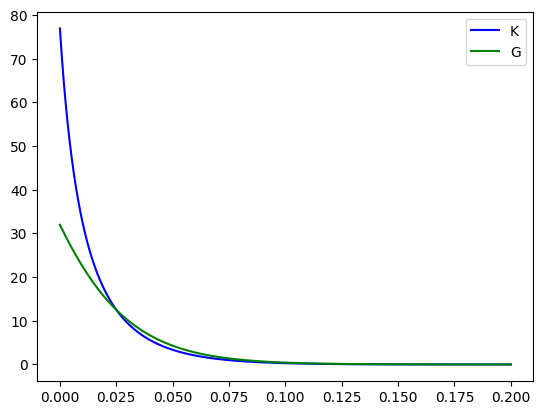

In [30]:
# Matrix properties
Km = 77.0 # GPa
Gm = 32.0 # GPa
rhom = 2.71 # g/cm3

# Fluid properties
Kf = 2.2 # GPa
rhof = 1.0 # g/cm3


# Porosity
phimax = 0.2

# Inclusion properties
# In this example a mixture of three inclusion types are used:
# - 30% of 0.02 aspect ratio
# - 50% of 0.15 aspect ratio
# - 20% of 0.80 aspect ratio
# alphas = np.array([0.01, 0.15, 0.8])
# volumes = np.array([0.3, 0.5, 0.2])*phimax

alphas = np.array([0.01])
volumes = np.array([1])*phimax

# Dry inclusions
Kis = np.zeros(len(alphas), dtype=float)
Gis = np.zeros(len(alphas), dtype=float)

# The DEM function returns the bulk and shear moduli along with the porosity array to match them.
# The porosity array is not regularly spaced. If you need so, you should reinterpolate.
K, G, phi = DEM(Km, Gm, Kis, Gis, alphas, volumes)

rho = (1.0 - phi)*rhom + phi*rhof
# Ks = Gassmann.Ks(K, Km, Kf, phi)

# Vp = np.sqrt((Ks + 4.0*G/3.0)/rho)
# Vs = np.sqrt(G/rho)

plt.plot(phi, K, 'b', label='K')
plt.plot(phi, G, 'g', label='G')

plt.legend()

plt.show()

In [18]:
from scipy.optimize import fsolve
from scipy.integrate import odeint

In [33]:
def PQ(Km,Gm, Ki,Gi, alpha):
    """compute geometric strain concentration factors P and Q for prolate and oblate spheroids according to Berymann (1980). See also PQ_vectorize

    Parameters
    ----------
    Km : float
        Bulk modulus of matrix phase
    Gm : float
        Shear modulus of matrix phase
    Ki : float
        Bulk modulus of inclusion phase
    Gi : float
        Shear modulus of inclusion phase
    alpha : float
        aspect ratio of the inclusion. Note that α <1 for oblate spheroids and α > 1 for prolate spheroids

    Returns
    -------
    float
        P,Q (unitless): geometric strain concentration factors
    """

    if alpha==1:
        P= (Km+4*Gm/3)/(Ki+4*Gm/3)
        kesai= Gm/6 *(9*Km+8*Gm)/(Km+2*Gm)
        Q= (Gm+kesai)/(Gi+kesai)

    else:

        if alpha<1:
            theta= alpha/(1.0 - alpha**2)**(3.0/2.0) * (np.arccos(alpha) - alpha*np.sqrt(1.0 - alpha**2))
        else:
            theta= alpha/(alpha**2-1)**(3.0/2.0) * ( alpha*(alpha**2-1)**0.5 -np.cosh(alpha)**-1)
        f= alpha**2*(3.0*theta - 2.0)/(1.0 - alpha**2)
        A = Gi/Gm - 1.0
        B = (Ki/Km - Gi/Gm)/3.0
        R = Gm/(Km + (4.0/3.0)*Gm) #
        F1 = 1.0 + A*(1.5*(f + theta) - R*(1.5*f + 2.5*theta - 4.0/3.0))
        F2 = 1.0 + A*(1.0 + 1.5*(f + theta) - R*(1.5*f + 2.5*theta)) + B*(3.0 - 4.0*R) + A*(A + 3.0*B)*(1.5 - 2.0*R)*(f + theta - R*(f - theta +
        2.0*theta**2))
        F3 = 1.0 + A*(1.0 - f - 1.5*theta + R*(f + theta))
        F4 = 1.0 + (A/4.0)*(f + 3.0*theta - R*(f - theta))
        F5 = A*(-f + R*(f + theta - 4.0/3.0)) + B*theta*(3.0 - 4.0*R)
        F6 = 1.0 + A*(1.0 + f - R*(f + theta)) + B*(1.0 - theta)*(3.0 - 4.0*R)
        F7 = 2.0 + (A/4.0)*(3.0*f + 9.0*theta - R*(3.0*f + 5.0*theta)) + B*theta*(3.0 - 4.0*R)
        F8 = A*(1.0 - 2.0*R + (f/2.0)*(R - 1.0) + (theta/2.0)*(5.0*R - 3.0)) + B*(1.0 - theta)*(3.0 - 4.0*R)
        F9 = A*((R - 1.0)*f - R*theta) + B*theta*(3.0 - 4.0*R)
        Tiijj = 3*F1/F2
        Tijij = Tiijj/3 + 2/F3 + 1/F4 + (F4*F5 + F6*F7 - F8*F9)/(F2*F4)
        P = Tiijj/3
        Q = (Tijij - P)/5
    return P, Q

In [34]:
def DEM(y,t, params):
    '''
    ODE solver tutorial: https://physics.nyu.edu/pine/pymanual/html/chap9/chap9_scipy.html.
    '''
    K_eff,G_eff=y  # unpack current values of y
    Gi,Ki,alpha = params # unpack parameters
    P, Q= PQ(G_eff,K_eff,Gi,Ki, alpha)
    derivs = [1/(1-t) * (Ki-K_eff) * P,  1/(1-t) * -G_eff * Q]
    return derivs


In [35]:
def Berryman_DEM(Km,Gm, Ki, Gi, alpha,phi):
    """Compute elastic moduli of two-phase composites by incrementally adding inclusions of one phase (phase 2) to the matrix phase using Berryman DEM theory

    Parameters
    ----------
    Km : float
        host mineral bulk modulus
    Gm : float
        host mineral shear modulus
    Ki : float
        bulk modulus of inclusion
    Gi : float
        shear modulus of inclusion
    alpha : float
        aspect ratio of the inclusion phase
    phi : float
        desired fraction occupied by the inclusion
    """
    #Bundle parameters for ODE solver
    params = [Gi,Ki,alpha]
    #Bundle initial conditions for ODE solver
    y0 = [Km,Gm]
    # Make time array for solution
    tStop = phi
    tInc = 0.01
    t = np.arange(0, tStop+tInc, tInc)
    psoln = odeint(DEM, y0, t, args=(params,))
    K_dry_dem=psoln[:,0]
    G_dry_dem=psoln[:,1]
    return K_dry_dem, G_dry_dem,t

In [36]:
Db, Kb = 1, 2.2 # brine density, bulk modulus
Do, Ko = 0.8, 1.5 # oil density, bulk modulus
Dg, Kg = 0.2, 0.06 # gas density, bulk modulus

In [40]:
Km = 77.0 # GPa
Gm = 32.0 # GPa

Ki, Gi = 0.06, 10**-6
alpha = 0.01
phi=0.2

In [41]:
a, b, c = Berryman_DEM(Km,Gm, Ki, Gi, alpha,phi)

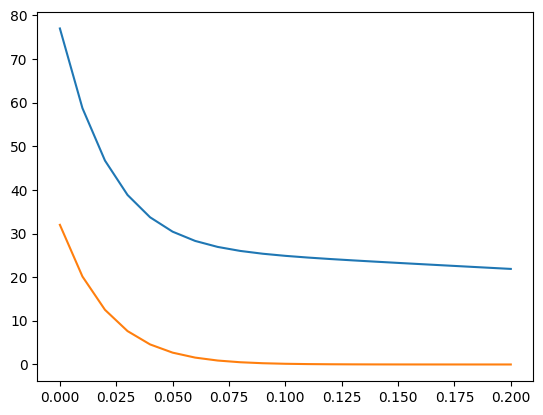

In [42]:
plt.plot(c, a)
plt.plot(c, b)

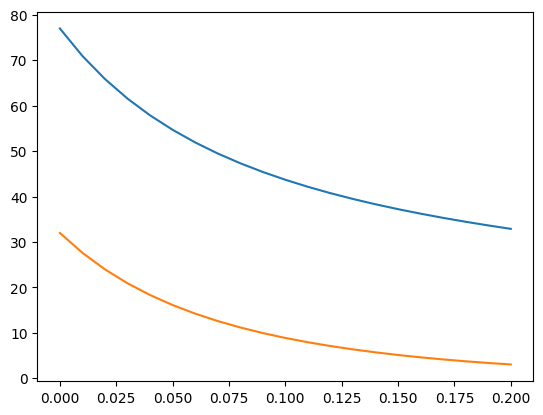

In [27]:
plt.plot(c, a)
plt.plot(c, b)